In [1]:
# IMPORTING LIBRARY

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('dark_background')

In [3]:
# IMPORTING DATA

from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/PORTOFOLIO/ojek_online_pricing_1000.csv')

print('\n')
print(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


       ID     km  waktu_menit  lokasi  jenis_kendaraan  macet  harga_ribu
0       1  11.86           59       3                2      5          52
1       2  18.31           69       2                1      3          57
2       3  26.12          130       2                2      5         128
3       4  29.13          128       3                1      4          87
4       5   6.32           27       1                1      4          25
..    ...    ...          ...     ...              ...    ...         ...
995   996   4.98           12       2                2      1          19
996   997  12.31           54       1                1      4          49
997   998  22.26           97       2                3      4         132
998   999  26.32           84       2                2      2         107
999  1000  17.26           65       3                1 

Descriptive Statistics:


                ID           km  waktu_menit       lokasi  jenis_kendaraan  \
count  1000.000000  1000.000000  1000.000000  1000.000000      1000.000000   
mean    500.500000    15.379590    58.313000     1.890000         1.537000   
std     288.819436     8.629616    35.842261     0.777499         0.726057   
min       1.000000     1.000000     2.000000     1.000000         1.000000   
25%     250.750000     7.837500    27.000000     1.000000         1.000000   
50%     500.500000    15.175000    57.000000     2.000000         1.000000   
75%     750.250000    22.897500    84.000000     3.000000         2.000000   
max    1000.000000    29.990000   149.000000     3.000000         3.000000   

             macet   harga_ribu  
count  1000.000000  1000.000000  
mean      3.044000    60.783000  
std       1.399293    39.878844  
min       1.000000     3.000000  
25%       2.000000    28.000000  
50%       3.000000    56.000000  
75%       4.000000    84.000000  

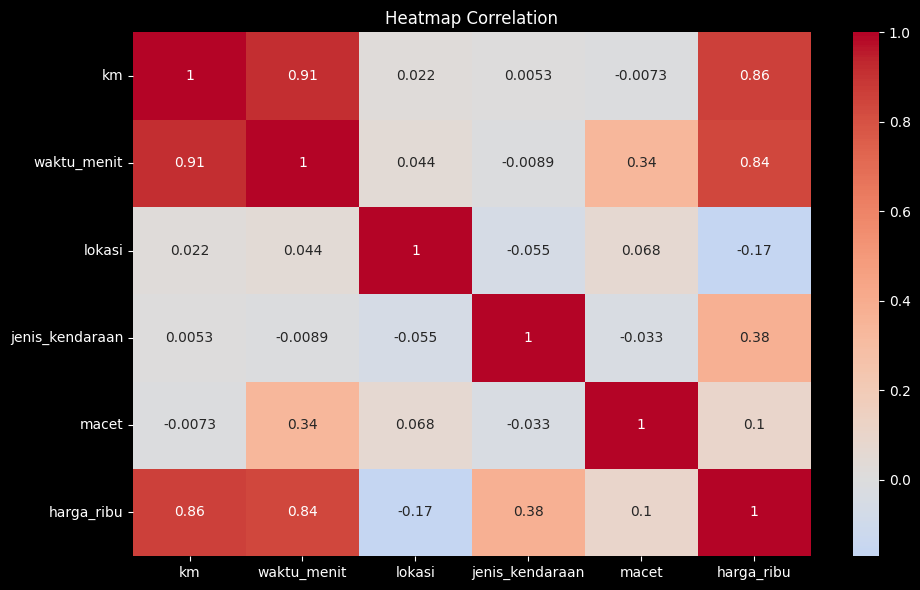

In [ ]:
# Descriptive Statistics

print('Descriptive Statistics:')
print('\n')
print(df.describe())
print('\n')

# CORRELATION BETWEEN FEATURES
print('Correlation towards harga_ribu:')
correlation = df.drop('ID', axis = 1).corr()['harga_ribu'].sort_values(ascending=False)
print(correlation)
print('\n')


# CORRELATION VISUALIZATION
plt.figure(figsize=(10,6))
sns.heatmap(df.drop('ID',axis=1).corr(), annot = True, cmap = 'coolwarm', center = 0)
plt.title('Heatmap Correlation')
plt.tight_layout()
plt.show()

In [ ]:
# SEEING DATA TRAINING

X = df[['km','waktu_menit','lokasi', 'jenis_kendaraan','macet']]
y = df[['harga_ribu']]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

print('Data Training (rows,columns): ', X_train.shape)
print('Data Test (rows,columns): ', X_test.shape)
print('\n')

df_train = X_train.copy()
df_train['harga_ribu'] = y_train
df_train = df_train.reset_index(drop=True)
print(df_train)

Data Training (rows,columns):  (800, 5)
Data Test (rows,columns):  (200, 5)


        km  waktu_menit  lokasi  jenis_kendaraan  macet  harga_ribu
0     5.68           14       3                2      1          19
1     2.52            6       2                1      1           7
2    29.02           75       3                3      1         127
3    11.53           29       3                1      1          28
4    15.24           57       3                1      3          43
..     ...          ...     ...              ...    ...         ...
795  28.55          142       3                1      5          90
796  10.25           38       3                1      3          29
797  15.86           60       1                2      3          83
798   2.05            6       1                1      2           7
799   7.92           30       2                2      3          34

[800 rows x 6 columns]


In [ ]:
# HYPERPARAMETER TUNING USING GridSearchCV

parameter_grid = {
    'n_estimators':[200,300],
    'max_depth': [None, 5,10,15],
    'min_samples_leaf':[2,3],
    'max_features':[1,2]
    }

grid = GridSearchCV(RandomForestRegressor(random_state=42), parameter_grid, cv=5, scoring = 'neg_mean_squared_error')

grid.fit(X_train, y_train)

print('Best Parameters: ', grid.best_params_)
print('Best Parameters Score (negative MSE): ', grid.best_score_)
print(f'Best Parameters Score (RMSE): Rp {round((-grid.best_score_)**0.5,2)} ribu')

Best Parameters:  {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2, 'n_estimators': 300}
Best Parameters Score (negative MSE):  -21.06421973727522
Best Parameters Score (RMSE): Rp 4.59 ribu


In [ ]:
# DATA MODELING

random_forest_model = RandomForestRegressor(
    n_estimators = 300,
    max_depth =  10,
    min_samples_leaf = 2,
    random_state = 42,
    bootstrap = True,
    oob_score = True,
    max_features = 2
)

random_forest_model.fit(X_train, y_train)

print('OOB Score: ', round(random_forest_model.oob_score_,4))
print('Tree Total: ', len(random_forest_model.estimators_))

OOB Score:  0.9879
Tree Total:  300


In [ ]:
# PREDICTION TOWARDS DATA TESTING USING MODEL
y_pred = random_forest_model.predict(X_test)

test_data = X_test.copy()
test_data['harga aktual'] = y_test.values
test_data['harga_prediksi'] = y_pred
test_data['selisih'] = np.abs(test_data['harga aktual']-test_data['harga_prediksi'])

# METRICS EVALUATION
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
oob = random_forest_model.oob_score_

print(f'MAE: {mae:.2f} ribu')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f} ribu')
print(f'R2: {r2:.4f}')
print(f'OOB Score: {oob:.4f}')


MAE: 2.29 ribu
MSE: 15.26
RMSE: 3.91 ribu
R2: 0.9921
OOB Score: 0.9879


In [ ]:
test_data.reset_index(drop=True)

,km,waktu_menit,lokasi,jenis_kendaraan,macet,harga aktual,harga_prediksi,selisih
0,1.70,4,3,1,1,4,5.701811,1.701811
1,7.35,23,2,3,2,38,33.583118,4.416882
2,29.04,127,1,3,4,207,182.079570,24.920430
3,15.83,60,2,1,3,49,51.183673,2.183673
4,7.87,29,3,1,3,22,24.194400,2.194400
...,...,...,...,...,...,...,...,...
195,19.36,96,3,2,5,85,86.864107,1.864107
196,5.34,17,2,2,2,22,21.718839,0.281161
197,3.96,19,3,2,5,17,18.493722,1.493722
198,12.44,62,2,1,5,44,44.542509,0.542509


In [ ]:
# PREDICTING RESULT OF NEW DATA USING MODEL

km = int(input('km: '))
waktu_menit = int(input('waktu_menit: '))
lokasi = int(input('lokasi: '))
jenis_kendaraan = int(input('jenis_kendaraan: '))
macet = int(input('macet: '))

new_data = pd.DataFrame({
    'km': [km],
    'waktu_menit': [waktu_menit],
    'lokasi': [lokasi],
    'jenis_kendaraan': [jenis_kendaraan],
    'macet': [macet]
})

new_data_pred = random_forest_model.predict(new_data)[0]
print('Rp.', round(new_data_pred,2), 'ribu')

km: 10
waktu_menit: 100
lokasi: 3
jenis_kendaraan: 3
macet: 5
Rp. 80.77 ribu
